### Loading the converted tensor RT pb graph

In [23]:
import tensorflow as tf
from tensorflow.python.platform import gfile
#GRAPH_PB_PATH = './trained_models_local/saved_for_lab/tf_model_base_1502.pb'
#GRAPH_PB_PATH = './converted_trt_graph/trt_graph_base_30.pb'
#GRAPH_PB_PATH = './converted_trt_graph/trt_graph_st_prg_1601_80p.pb'
GRAPH_PB_PATH_FROZEN='./save-pb/frozen_model_ss_plf.pb'
#GRAPH_PB_PATH_TRT = './converted_trt_graph/trt_graph_ss_model.pb'

with tf.Session() as sess:
   print("load graph")
   with gfile.FastGFile(GRAPH_PB_PATH_FROZEN,'rb') as f:
       graph_def = tf.GraphDef()
   graph_def.ParseFromString(f.read())
   sess.graph.as_default()
   tf.import_graph_def(graph_def, name='')
   graph_nodes=[n for n in graph_def.node]
   names = []
   for t in graph_nodes:
      names.append(t.name)
    
    # print operations

   print(names)

load graph
['input_1', 'stem_conv/kernel', 'stem_conv/Conv2D/ReadVariableOp', 'stem_conv/Conv2D', 'stem_bn/gamma', 'stem_bn/beta', 'stem_bn/moving_mean', 'stem_bn/moving_variance', 'stem_bn/ReadVariableOp', 'stem_bn/ReadVariableOp_1', 'stem_bn/FusedBatchNormV3/ReadVariableOp', 'stem_bn/FusedBatchNormV3/ReadVariableOp_1', 'stem_bn/FusedBatchNormV3', 'stem_activation/Sigmoid', 'stem_activation/mul', 'stem_activation/IdentityN', 'block1a_dwconv/depthwise_kernel', 'block1a_dwconv/depthwise/ReadVariableOp', 'block1a_dwconv/depthwise', 'block1a_bn/gamma', 'block1a_bn/beta', 'block1a_bn/moving_mean', 'block1a_bn/moving_variance', 'block1a_bn/ReadVariableOp', 'block1a_bn/ReadVariableOp_1', 'block1a_bn/FusedBatchNormV3/ReadVariableOp', 'block1a_bn/FusedBatchNormV3/ReadVariableOp_1', 'block1a_bn/FusedBatchNormV3', 'block1a_activation/Sigmoid', 'block1a_activation/mul', 'block1a_activation/IdentityN', 'block1a_se_squeeze/Mean/reduction_indices', 'block1a_se_squeeze/Mean', 'block1a_se_reshape/Shap

### Importing the graph

In [24]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(graph_def, name='')

### loading the first and last layers

In [25]:
tf_input = tf_sess.graph.get_tensor_by_name('input_1:0')
print(tf_input)

tf_predictions = tf_sess.graph.get_tensor_by_name('sigmoid/Sigmoid:0')
print(tf_predictions)



Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("sigmoid/Sigmoid:0", shape=(?, ?, ?, 1), dtype=float32)


### Inference time for 5 images

In [26]:
import time

num_samples = 5

t0 = time.time()
for i in range(num_samples):
    inputs, predictions = tf_sess.run([tf_input, tf_predictions], feed_dict={
    tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.401333 seconds


### Load a single image

In [27]:
#IMAGE_PATH = './0001TP_009270.png'
IMAGE_PATH = './0001TP_009060.png'



### Visualize the image

(320, 480, 3)


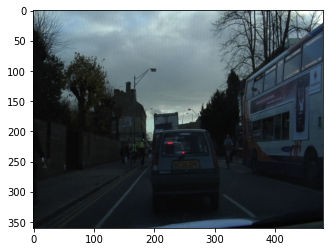

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((480, 320)))
print(image_resized.shape)
image = np.array(image)

### Visualization helper functions

In [ ]:
# helper function for data visualization    
from IPython.display import clear_output

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        clear_output(wait=True)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

print("done")

### Predictions of the mask on a single image

In [29]:
import cv2

from tensorflow.python.keras.backend import set_session
graph = tf.get_default_graph()

with graph.as_default():
    set_session(sess)
    inputs, predictions = tf_sess.run([tf_input, tf_predictions], feed_dict={
    tf_input: image_resized[None, ...]
})

#print("type",type(predictions))
#print(predictions)
#array = np.reshape(array, (1024, 720))
#array = np.reshape(predictions, (320,480))
#array = np.ones([320, 480, 1], dtype=np.float)
#print(array.shape)

#The below block executes in opencv

#------------start block of opencv---------------------------

#cv2.imwrite('file5.jpeg', 255*predictions.squeeze())
pred_image = 255*predictions.squeeze()

##converts pred_image to CV_8UC1 format so that ColorMap can be applied on it
u8 = pred_image.astype(np.uint8)

#Color map autumn is applied to the CV_8UC1 pred_image
im_color = cv2.applyColorMap(u8, cv2.COLORMAP_AUTUMN)

#below line will directly show you the prediction mask without any color map, then you can comment all the 
#above 3 lines. A number of 255 is multiplied because the prediction values are so small and are converted
#to the pixel values from 0-255
#---------------------------------------------------------
#cv2.imshow('img',255*predictions.squeeze())
#---------------------------------------------------------

#Below version just shows the mask with the color map

#---------------------------------------------------------
cv2.imshow('img',im_color)
cv2.waitKey(0)
cv2.destroyWindow('img')
#---------------------------------------------------------

#------------end block of opencv------------------------------






#Uncomment the below if you want to see the images executed here in the jupyter notebook
'''
visualize(
        image=denormalize(image.squeeze()),
        gt_mask=predictions[..., 0].squeeze(),
    )
'''

'\nvisualize(\n        image=denormalize(image.squeeze()),\n        gt_mask=predictions[..., 0].squeeze(),\n    )\n'

### Real time prediction of the mask from the camera

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


from tensorflow.python.keras.backend import set_session
graph = tf.get_default_graph()


#Capture the video from the camera

cap = cv2.VideoCapture(0)
#cap.set(cv2.CAP_PROP_FRAME_WIDTH, 480)
#cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 300)
# For streams:
#   cap = cv2.VideoCapture('rtsp://url.to.stream/media.amqp')
# Or e.g. most common ID for webcams:
#   cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    #frame2 = frame.reshape((300,480))
    image_resized2 = cv2.resize(frame, (480,320))
    #print(resized.shape)
    #frame2 = np.expand_dims(resized, axis=0)
    
    #Run the Detections using model.predict

    if ret:
        t0 = time.time()
        with graph.as_default():
            set_session(sess)
            inputs, predictions = tf_sess.run([tf_input, tf_predictions], feed_dict={
            tf_input: image_resized2[None, ...]
        })
        #cv2.imwrite('file5.jpeg', 255*predictions.squeeze())
        pred_image = 255*predictions.squeeze()

        ##converts pred_image to CV_8UC1 format so that ColorMap can be applied on it
        u8 = pred_image.astype(np.uint8)

        #Color map autumn is applied to the CV_8UC1 pred_image
        im_color = cv2.applyColorMap(u8, cv2.COLORMAP_AUTUMN)
        cv2.imshow('input image', image_resized2)
        cv2.imshow('prediction mask',im_color)
        t1 = time.time()
        print('Runtime: %f seconds' % (float(t1 - t0)))
        #cv2.waitKey(0)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


    else:
        cap.release()
        break

cap.release()
cv2.destroyAllWindows()

Runtime: 0.034239 seconds
Runtime: 0.020426 seconds
Runtime: 0.021071 seconds
Runtime: 0.021379 seconds
Runtime: 0.020725 seconds
Runtime: 0.020412 seconds
Runtime: 0.019818 seconds
Runtime: 0.019073 seconds
Runtime: 0.021679 seconds
Runtime: 0.020229 seconds
Runtime: 0.019934 seconds
Runtime: 0.019888 seconds
Runtime: 0.020042 seconds
Runtime: 0.019628 seconds
Runtime: 0.020299 seconds
Runtime: 0.019740 seconds
Runtime: 0.020175 seconds
Runtime: 0.020141 seconds
Runtime: 0.020537 seconds
Runtime: 0.019401 seconds
Runtime: 0.020483 seconds
Runtime: 0.019326 seconds
Runtime: 0.019861 seconds
Runtime: 0.019628 seconds
Runtime: 0.019903 seconds
Runtime: 0.019590 seconds
Runtime: 0.020063 seconds
Runtime: 0.019314 seconds
Runtime: 0.020038 seconds
Runtime: 0.019638 seconds
Runtime: 0.020041 seconds
Runtime: 0.019859 seconds
Runtime: 0.019806 seconds
Runtime: 0.019787 seconds
Runtime: 0.021321 seconds
Runtime: 0.021468 seconds
Runtime: 0.020736 seconds
Runtime: 0.019820 seconds
Runtime: 0.0